In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2024-01-03 21:15:43.431528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2012'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(start_year), int(end_month), int(end_day))
t = (int(end_year)-int(start_year)+1)*(numOfDays(date1, date2)+1)

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
            list_of_file_names.append(all_file_names) # all days in month
elif int(start_year)<int(end_year):
    for i in range(int(start_year),int(end_year)+1,1):
            for m in range(int(start_month),int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+str(i)+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                month=[]
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
  
print(len(list_of_files))

8778


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010400.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010500.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010600.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010700.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010800.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010900.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011000.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011100.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011200.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011300.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011400.nc
14
/prj/

/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
123
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
124
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
125
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060600.nc
126
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060700.nc
127
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060800.nc
128
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060900.nc
129
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061000.nc
130
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061100.nc
131
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061200.nc
132
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061300.nc
133
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061400.nc
134
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061500.nc
135
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061600.nc
136
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110500.nc
245
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
246
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110700.nc
247
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110800.nc
248
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110900.nc
249
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111000.nc
250
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111100.nc
251
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111200.nc
252
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111300.nc
253
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111400.nc
254
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111500.nc
255
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111600.nc
256
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111700.nc
257
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111800.nc
258
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160700.nc
367
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160800.nc
368
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160900.nc
369
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161000.nc
370
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161100.nc
371
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161200.nc
372
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161300.nc
373
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161400.nc
374
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161500.nc
375
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161600.nc
376
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161700.nc
377
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161800.nc
378
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161900.nc
379
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006162000.nc
380
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_

487
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210800.nc
488
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210900.nc
489
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211000.nc
490
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211100.nc
491
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211200.nc
492
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211300.nc
493
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211400.nc
494
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211500.nc
495
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211600.nc
496
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211700.nc
497
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211800.nc
498
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211900.nc
499
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212000.nc
500
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212100.nc
501
/prj/nflics/hist_cores/2010/06/21/Hist_cores

609
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261000.nc
610
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261100.nc
611
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261200.nc
612
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261300.nc
613
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261400.nc
614
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261500.nc
615
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261600.nc
616
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261700.nc
617
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261800.nc
618
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261900.nc
619
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262000.nc
620
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262100.nc
621
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262200.nc
622
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262300.nc
623
/prj/nflics/hist_cores/2010/06/27/Hist_cores

/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011100.nc
731
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011200.nc
732
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011300.nc
733
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011400.nc
734
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011500.nc
735
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011600.nc
736
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011700.nc
737
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011800.nc
738
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011900.nc
739
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012000.nc
740
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012100.nc
741
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012200.nc
742
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012300.nc
743
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020000.nc
744
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_

851
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061200.nc
852
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061300.nc
853
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061400.nc
854
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061500.nc
855
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061600.nc
856
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061700.nc
857
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061800.nc
858
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061900.nc
859
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062000.nc
860
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062100.nc
861
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062200.nc
862
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062300.nc
863
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070000.nc
864
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070100.nc
865
/prj/nflics/hist_cores/2010/07/07/Hist_cores

/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111400.nc
974
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111500.nc
975
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111600.nc
976
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111700.nc
977
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111800.nc
978
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111900.nc
979
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112000.nc
980
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112100.nc
981
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112200.nc
982
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112300.nc
983
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120000.nc
984
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120100.nc
985
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120200.nc
986
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120300.nc
987
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161500.nc
1095
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161600.nc
1096
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161700.nc
1097
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161800.nc
1098
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161900.nc
1099
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162000.nc
1100
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162100.nc
1101
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162200.nc
1102
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162300.nc
1103
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170000.nc
1104
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170100.nc
1105
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170200.nc
1106
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170300.nc
1107
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170400.nc
1108
/prj/nflics/hist_cores/2010/07/17/

1213
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211400.nc
1214
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211500.nc
1215
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211600.nc
1216
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211700.nc
1217
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211800.nc
1218
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211900.nc
1219
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212000.nc
1220
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212100.nc
1221
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212200.nc
1222
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212300.nc
1223
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220000.nc
1224
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220100.nc
1225
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220200.nc
1226
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220300.nc
1227
/prj/nflics/hist_cores/2010/0

1332
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261300.nc
1333
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261400.nc
1334
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261500.nc
1335
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261600.nc
1336
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261700.nc
1337
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261800.nc
1338
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261900.nc
1339
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262000.nc
1340
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262100.nc
1341
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262200.nc
1342
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262300.nc
1343
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270000.nc
1344
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270100.nc
1345
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270200.nc
1346
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311200.nc
1452
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311300.nc
1453
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311400.nc
1454
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311500.nc
1455
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311600.nc
1456
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311700.nc
1457
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311800.nc
1458
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311900.nc
1459
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312000.nc
1460
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312100.nc
1461
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312200.nc
1462
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312300.nc
1463
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010000.nc
1464
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010100.nc
1465
/prj/nflics/hist_cores/2010/08/01/

/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051200.nc
1572
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051300.nc
1573
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051400.nc
1574
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051500.nc
1575
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051600.nc
1576
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051700.nc
1577
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051800.nc
1578
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051900.nc
1579
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052000.nc
1580
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052100.nc
1581
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052200.nc
1582
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052300.nc
1583
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060000.nc
1584
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060100.nc
1585
/prj/nflics/hist_cores/2010/08/06/

/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101200.nc
1692
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101300.nc
1693
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101400.nc
1694
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101500.nc
1695
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101600.nc
1696
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101700.nc
1697
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101800.nc
1698
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101900.nc
1699
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102000.nc
1700
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102100.nc
1701
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102200.nc
1702
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102300.nc
1703
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110000.nc
1704
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110100.nc
1705
/prj/nflics/hist_cores/2010/08/11/

/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151100.nc
1811
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151200.nc
1812
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151300.nc
1813
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151400.nc
1814
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151500.nc
1815
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151600.nc
1816
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151700.nc
1817
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151800.nc
1818
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151900.nc
1819
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152000.nc
1820
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152100.nc
1821
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152200.nc
1822
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152300.nc
1823
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160000.nc
1824
/prj/nflics/hist_cores/2010/08/16/

1929
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201000.nc
1930
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201100.nc
1931
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201200.nc
1932
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201300.nc
1933
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201400.nc
1934
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201500.nc
1935
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201600.nc
1936
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201700.nc
1937
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201800.nc
1938
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201900.nc
1939
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202000.nc
1940
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202100.nc
1941
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202200.nc
1942
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202300.nc
1943
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250900.nc
2049
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251000.nc
2050
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251100.nc
2051
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251200.nc
2052
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251300.nc
2053
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251400.nc
2054
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251500.nc
2055
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251600.nc
2056
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251700.nc
2057
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251800.nc
2058
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251900.nc
2059
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252000.nc
2060
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252100.nc
2061
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252200.nc
2062
/prj/nflics/hist_cores/2010/08/25/

2168
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300900.nc
2169
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301000.nc
2170
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301100.nc
2171
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301200.nc
2172
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301300.nc
2173
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301400.nc
2174
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301500.nc
2175
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301600.nc
2176
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301700.nc
2177
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301800.nc
2178
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301900.nc
2179
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302000.nc
2180
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302100.nc
2181
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302200.nc
2182
/prj/nflics/hist_cores/2010/0

2287
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040800.nc
2288
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040900.nc
2289
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041000.nc
2290
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041100.nc
2291
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041200.nc
2292
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041300.nc
2293
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041400.nc
2294
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041500.nc
2295
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041600.nc
2296
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041700.nc
2297
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041800.nc
2298
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041900.nc
2299
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042000.nc
2300
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042100.nc
2301
/prj/nflics/hist_cores/2010/0

2407
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090800.nc
2408
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090900.nc
2409
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091000.nc
2410
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091100.nc
2411
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091200.nc
2412
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091300.nc
2413
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091400.nc
2414
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091500.nc
2415
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091600.nc
2416
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091700.nc
2417
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091800.nc
2418
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091900.nc
2419
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092000.nc
2420
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092100.nc
2421
/prj/nflics/hist_cores/2010/0

2526
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140700.nc
2527
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140800.nc
2528
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140900.nc
2529
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141000.nc
2530
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141100.nc
2531
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141200.nc
2532
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141300.nc
2533
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141400.nc
2534
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141500.nc
2535
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141600.nc
2536
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141700.nc
2537
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141800.nc
2538
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141900.nc
2539
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142000.nc
2540
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190600.nc
2646
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190700.nc
2647
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190800.nc
2648
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190900.nc
2649
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191000.nc
2650
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191100.nc
2651
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191200.nc
2652
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191300.nc
2653
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191400.nc
2654
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191500.nc
2655
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191600.nc
2656
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191700.nc
2657
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191800.nc
2658
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191900.nc
2659
/prj/nflics/hist_cores/2010/09/19/

/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240500.nc
2765
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240600.nc
2766
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240700.nc
2767
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240800.nc
2768
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240900.nc
2769
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241000.nc
2770
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241100.nc
2771
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241200.nc
2772
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241300.nc
2773
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241400.nc
2774
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241500.nc
2775
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241600.nc
2776
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241700.nc
2777
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241800.nc
2778
/prj/nflics/hist_cores/2010/09/24/

/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290400.nc
2884
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290500.nc
2885
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290600.nc
2886
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290700.nc
2887
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290800.nc
2888
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290900.nc
2889
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291000.nc
2890
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291100.nc
2891
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291200.nc
2892
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291300.nc
2893
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291400.nc
2894
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291500.nc
2895
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291600.nc
2896
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291700.nc
2897
/prj/nflics/hist_cores/2010/09/29/

3003
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040400.nc
3004
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040500.nc
3005
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040600.nc
3006
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040700.nc
3007
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040800.nc
3008
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040900.nc
3009
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041000.nc
3010
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041100.nc
3011
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041200.nc
3012
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041300.nc
3013
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041400.nc
3014
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041500.nc
3015
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041600.nc
3016
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041700.nc
3017
/prj/nflics/hist_cores/2011/0

3122
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090300.nc
3123
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090400.nc
3124
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090500.nc
3125
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090600.nc
3126
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090700.nc
3127
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090800.nc
3128
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090900.nc
3129
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091000.nc
3130
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091100.nc
3131
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091200.nc
3132
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091300.nc
3133
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091400.nc
3134
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091500.nc
3135
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091600.nc
3136
/prj/nflics/hist_cores/2011/0

3242
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140300.nc
3243
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140400.nc
3244
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140500.nc
3245
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140600.nc
3246
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140700.nc
3247
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140800.nc
3248
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140900.nc
3249
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141000.nc
3250
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141100.nc
3251
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141200.nc
3252
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141300.nc
3253
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141400.nc
3254
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141500.nc
3255
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141600.nc
3256
/prj/nflics/hist_cores/2011/0

3362
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190300.nc
3363
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190400.nc
3364
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190500.nc
3365
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190600.nc
3366
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190700.nc
3367
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190800.nc
3368
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190900.nc
3369
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191000.nc
3370
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191100.nc
3371
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191200.nc
3372
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191300.nc
3373
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191400.nc
3374
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191500.nc
3375
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191600.nc
3376
/prj/nflics/hist_cores/2011/0

3481
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240200.nc
3482
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240300.nc
3483
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240400.nc
3484
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240500.nc
3485
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240600.nc
3486
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240700.nc
3487
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240800.nc
3488
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240900.nc
3489
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241000.nc
3490
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241100.nc
3491
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241200.nc
3492
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241300.nc
3493
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241400.nc
3494
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241500.nc
3495
/prj/nflics/hist_cores/2011/0

3601
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290200.nc
3602
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290300.nc
3603
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290400.nc
3604
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290500.nc
3605
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290600.nc
3606
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290700.nc
3607
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290800.nc
3608
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290900.nc
3609
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291000.nc
3610
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291100.nc
3611
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291200.nc
3612
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291300.nc
3613
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291400.nc
3614
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291500.nc
3615
/prj/nflics/hist_cores/2011/0

3721
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040200.nc
3722
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040300.nc
3723
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040400.nc
3724
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040500.nc
3725
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040600.nc
3726
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040700.nc
3727
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040800.nc
3728
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040900.nc
3729
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041000.nc
3730
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041100.nc
3731
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041200.nc
3732
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041300.nc
3733
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041400.nc
3734
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041500.nc
3735
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090100.nc
3841
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090200.nc
3842
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090300.nc
3843
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090400.nc
3844
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090500.nc
3845
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090600.nc
3846
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090700.nc
3847
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090800.nc
3848
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090900.nc
3849
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091000.nc
3850
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091100.nc
3851
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091200.nc
3852
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091300.nc
3853
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091400.nc
3854
/prj/nflics/hist_cores/2011/07/09/

/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140100.nc
3961
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140200.nc
3962
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140300.nc
3963
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140400.nc
3964
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140500.nc
3965
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140600.nc
3966
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140700.nc
3967
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140800.nc
3968
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140900.nc
3969
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141000.nc
3970
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141100.nc
3971
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141200.nc
3972
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141300.nc
3973
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141400.nc
3974
/prj/nflics/hist_cores/2011/07/14/

4081
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190200.nc
4082
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190300.nc
4083
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190400.nc
4084
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190500.nc
4085
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190600.nc
4086
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190700.nc
4087
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190800.nc
4088
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190900.nc
4089
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191000.nc
4090
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191100.nc
4091
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191200.nc
4092
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191300.nc
4093
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191400.nc
4094
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191500.nc
4095
/prj/nflics/hist_cores/2011/0

4201
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240200.nc
4202
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240300.nc
4203
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240400.nc
4204
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240500.nc
4205
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240600.nc
4206
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240700.nc
4207
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240800.nc
4208
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240900.nc
4209
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241000.nc
4210
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241100.nc
4211
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241200.nc
4212
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241300.nc
4213
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241400.nc
4214
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241500.nc
4215
/prj/nflics/hist_cores/2011/0

4320
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290100.nc
4321
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290200.nc
4322
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290300.nc
4323
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290400.nc
4324
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290500.nc
4325
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290600.nc
4326
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290700.nc
4327
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290800.nc
4328
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290900.nc
4329
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291000.nc
4330
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291100.nc
4331
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291200.nc
4332
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291300.nc
4333
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291400.nc
4334
/prj/nflics/hist_cores/2011/0

4439
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030000.nc
4440
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030100.nc
4441
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030200.nc
4442
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030300.nc
4443
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030400.nc
4444
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030500.nc
4445
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030600.nc
4446
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030700.nc
4447
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030800.nc
4448
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030900.nc
4449
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031000.nc
4450
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031100.nc
4451
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031200.nc
4452
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031300.nc
4453
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108072300.nc
4559
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080000.nc
4560
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080100.nc
4561
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080200.nc
4562
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080300.nc
4563
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080400.nc
4564
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080500.nc
4565
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080600.nc
4566
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080700.nc
4567
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080800.nc
4568
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080900.nc
4569
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081000.nc
4570
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081100.nc
4571
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081200.nc
4572
/prj/nflics/hist_cores/2011/08/08/

/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108122200.nc
4678
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108122300.nc
4679
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130000.nc
4680
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130100.nc
4681
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130200.nc
4682
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130300.nc
4683
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130400.nc
4684
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130500.nc
4685
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130600.nc
4686
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130700.nc
4687
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130800.nc
4688
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130900.nc
4689
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131000.nc
4690
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131100.nc
4691
/prj/nflics/hist_cores/2011/08/13/

4796
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108172100.nc
4797
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108172200.nc
4798
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108172300.nc
4799
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180000.nc
4800
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180100.nc
4801
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180200.nc
4802
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180300.nc
4803
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180400.nc
4804
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180500.nc
4805
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180600.nc
4806
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180700.nc
4807
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180800.nc
4808
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180900.nc
4809
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181000.nc
4810
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108222100.nc
4917
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108222200.nc
4918
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108222300.nc
4919
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230000.nc
4920
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230100.nc
4921
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230200.nc
4922
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230300.nc
4923
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230400.nc
4924
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230500.nc
4925
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230600.nc
4926
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230700.nc
4927
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230800.nc
4928
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230900.nc
4929
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231000.nc
4930
/prj/nflics/hist_cores/2011/08/23/

/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272000.nc
5036
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272100.nc
5037
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272200.nc
5038
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272300.nc
5039
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280000.nc
5040
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280100.nc
5041
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280200.nc
5042
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280300.nc
5043
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280400.nc
5044
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280500.nc
5045
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280600.nc
5046
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280700.nc
5047
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280800.nc
5048
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280900.nc
5049
/prj/nflics/hist_cores/2011/08/28/

5155
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012000.nc
5156
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012100.nc
5157
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012200.nc
5158
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012300.nc
5159
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020000.nc
5160
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020100.nc
5161
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020200.nc
5162
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020300.nc
5163
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020400.nc
5164
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020500.nc
5165
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020600.nc
5166
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020700.nc
5167
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020800.nc
5168
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020900.nc
5169
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061900.nc
5275
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062000.nc
5276
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062100.nc
5277
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062200.nc
5278
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062300.nc
5279
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070000.nc
5280
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070100.nc
5281
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070200.nc
5282
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070300.nc
5283
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070400.nc
5284
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070500.nc
5285
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070600.nc
5286
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070700.nc
5287
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070800.nc
5288
/prj/nflics/hist_cores/2011/09/07/

5394
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111900.nc
5395
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112000.nc
5396
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112100.nc
5397
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112200.nc
5398
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112300.nc
5399
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120000.nc
5400
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120100.nc
5401
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120200.nc
5402
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120300.nc
5403
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120400.nc
5404
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120500.nc
5405
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120600.nc
5406
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120700.nc
5407
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120800.nc
5408
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161800.nc
5514
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161900.nc
5515
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162000.nc
5516
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162100.nc
5517
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162200.nc
5518
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162300.nc
5519
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170000.nc
5520
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170100.nc
5521
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170200.nc
5522
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170300.nc
5523
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170400.nc
5524
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170500.nc
5525
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170600.nc
5526
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170700.nc
5527
/prj/nflics/hist_cores/2011/09/17/

5632
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211700.nc
5633
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211800.nc
5634
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211900.nc
5635
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212000.nc
5636
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212100.nc
5637
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212200.nc
5638
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212300.nc
5639
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220000.nc
5640
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220100.nc
5641
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220200.nc
5642
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220300.nc
5643
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220400.nc
5644
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220500.nc
5645
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220600.nc
5646
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261600.nc
5752
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261700.nc
5753
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261800.nc
5754
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261900.nc
5755
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262000.nc
5756
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262100.nc
5757
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262200.nc
5758
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262300.nc
5759
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270000.nc
5760
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270100.nc
5761
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270200.nc
5762
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270300.nc
5763
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270400.nc
5764
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270500.nc
5765
/prj/nflics/hist_cores/2011/09/27/

5871
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011600.nc
5872
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011700.nc
5873
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011800.nc
5874
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011900.nc
5875
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012000.nc
5876
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012100.nc
5877
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012200.nc
5878
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012300.nc
5879
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020000.nc
5880
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020100.nc
5881
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020200.nc
5882
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020300.nc
5883
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020400.nc
5884
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020500.nc
5885
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061600.nc
5992
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061700.nc
5993
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061800.nc
5994
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061900.nc
5995
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062000.nc
5996
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062100.nc
5997
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062200.nc
5998
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062300.nc
5999
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070000.nc
6000
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070100.nc
6001
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070200.nc
6002
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070300.nc
6003
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070400.nc
6004
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070500.nc
6005
/prj/nflics/hist_cores/2012/06/07/

/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111500.nc
6111
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111600.nc
6112
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111700.nc
6113
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111800.nc
6114
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111900.nc
6115
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112000.nc
6116
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112100.nc
6117
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112200.nc
6118
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112300.nc
6119
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120000.nc
6120
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120100.nc
6121
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120200.nc
6122
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120300.nc
6123
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120400.nc
6124
/prj/nflics/hist_cores/2012/06/12/

6230
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161500.nc
6231
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161600.nc
6232
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161700.nc
6233
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161800.nc
6234
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161900.nc
6235
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162000.nc
6236
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162100.nc
6237
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162200.nc
6238
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162300.nc
6239
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170000.nc
6240
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170100.nc
6241
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170200.nc
6242
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170300.nc
6243
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170400.nc
6244
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211400.nc
6350
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211500.nc
6351
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211600.nc
6352
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211700.nc
6353
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211800.nc
6354
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211900.nc
6355
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212000.nc
6356
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212100.nc
6357
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212200.nc
6358
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212300.nc
6359
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220000.nc
6360
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220100.nc
6361
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220200.nc
6362
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220300.nc
6363
/prj/nflics/hist_cores/2012/06/22/

/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261400.nc
6470
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261500.nc
6471
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261600.nc
6472
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261700.nc
6473
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261800.nc
6474
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261900.nc
6475
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262000.nc
6476
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262100.nc
6477
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262200.nc
6478
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262300.nc
6479
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270000.nc
6480
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270100.nc
6481
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270200.nc
6482
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270300.nc
6483
/prj/nflics/hist_cores/2012/06/27/

/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011400.nc
6590
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011500.nc
6591
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011600.nc
6592
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011700.nc
6593
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011800.nc
6594
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011900.nc
6595
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012000.nc
6596
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012100.nc
6597
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012200.nc
6598
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012300.nc
6599
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020000.nc
6600
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020100.nc
6601
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020200.nc
6602
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020300.nc
6603
/prj/nflics/hist_cores/2012/07/02/

/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062000.nc
6710
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062100.nc
6711
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062200.nc
6712
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062300.nc
6713
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070000.nc
6714
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070100.nc
6715
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070200.nc
6716
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070300.nc
6717
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070400.nc
6718
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070500.nc
6719
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070600.nc
6720
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070700.nc
6721
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070800.nc
6722
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070900.nc
6723
/prj/nflics/hist_cores/2012/07/07/

/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111900.nc
6829
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112000.nc
6830
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112100.nc
6831
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112200.nc
6832
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112300.nc
6833
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120000.nc
6834
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120100.nc
6835
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120200.nc
6836
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120300.nc
6837
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120400.nc
6838
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120500.nc
6839
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120600.nc
6840
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120700.nc
6841
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120800.nc
6842
/prj/nflics/hist_cores/2012/07/12/

6947
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161800.nc
6948
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161900.nc
6949
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162000.nc
6950
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162100.nc
6951
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162200.nc
6952
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162300.nc
6953
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170000.nc
6954
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170100.nc
6955
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170200.nc
6956
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170300.nc
6957
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170400.nc
6958
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170500.nc
6959
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170600.nc
6960
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170700.nc
6961
/prj/nflics/hist_cores/2012/0

7066
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211700.nc
7067
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211800.nc
7068
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211900.nc
7069
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212000.nc
7070
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212100.nc
7071
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212200.nc
7072
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212300.nc
7073
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220000.nc
7074
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220100.nc
7075
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220200.nc
7076
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220300.nc
7077
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220400.nc
7078
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220500.nc
7079
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220600.nc
7080
/prj/nflics/hist_cores/2012/0

7186
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261700.nc
7187
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261800.nc
7188
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261900.nc
7189
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262000.nc
7190
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262100.nc
7191
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262200.nc
7192
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262300.nc
7193
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270000.nc
7194
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270100.nc
7195
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270200.nc
7196
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270300.nc
7197
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270400.nc
7198
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270500.nc
7199
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270600.nc
7200
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311600.nc
7306
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311700.nc
7307
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311800.nc
7308
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311900.nc
7309
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312000.nc
7310
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312100.nc
7311
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312200.nc
7312
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312300.nc
7313
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010000.nc
7314
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010100.nc
7315
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010200.nc
7316
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010300.nc
7317
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010400.nc
7318
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010500.nc
7319
/prj/nflics/hist_cores/2012/08/01/

/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051500.nc
7425
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051600.nc
7426
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051700.nc
7427
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051800.nc
7428
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051900.nc
7429
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052000.nc
7430
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052100.nc
7431
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052200.nc
7432
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052300.nc
7433
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060000.nc
7434
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060100.nc
7435
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060200.nc
7436
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060300.nc
7437
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060400.nc
7438
/prj/nflics/hist_cores/2012/08/06/

7543
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101400.nc
7544
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101500.nc
7545
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101600.nc
7546
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101700.nc
7547
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101800.nc
7548
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101900.nc
7549
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102000.nc
7550
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102100.nc
7551
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102200.nc
7552
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102300.nc
7553
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110000.nc
7554
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110100.nc
7555
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110200.nc
7556
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110300.nc
7557
/prj/nflics/hist_cores/2012/0

7662
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151300.nc
7663
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151400.nc
7664
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151500.nc
7665
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151600.nc
7666
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151700.nc
7667
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151800.nc
7668
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151900.nc
7669
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152000.nc
7670
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152100.nc
7671
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152200.nc
7672
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152300.nc
7673
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160000.nc
7674
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160100.nc
7675
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160200.nc
7676
/prj/nflics/hist_cores/2012/0

7782
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201300.nc
7783
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201400.nc
7784
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201500.nc
7785
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201600.nc
7786
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201700.nc
7787
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201800.nc
7788
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201900.nc
7789
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202000.nc
7790
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202100.nc
7791
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202200.nc
7792
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202300.nc
7793
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210000.nc
7794
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210100.nc
7795
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210200.nc
7796
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251300.nc
7903
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251400.nc
7904
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251500.nc
7905
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251600.nc
7906
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251700.nc
7907
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251800.nc
7908
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251900.nc
7909
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252000.nc
7910
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252100.nc
7911
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252200.nc
7912
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252300.nc
7913
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260000.nc
7914
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260100.nc
7915
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260200.nc
7916
/prj/nflics/hist_cores/2012/08/26/

8021
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301200.nc
8022
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301300.nc
8023
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301400.nc
8024
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301500.nc
8025
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301600.nc
8026
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301700.nc
8027
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301800.nc
8028
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301900.nc
8029
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302000.nc
8030
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302100.nc
8031
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302200.nc
8032
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302300.nc
8033
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310000.nc
8034
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310100.nc
8035
/prj/nflics/hist_cores/2012/0

8140
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041100.nc
8141
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041200.nc
8142
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041300.nc
8143
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041400.nc
8144
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041500.nc
8145
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041600.nc
8146
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041700.nc
8147
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041800.nc
8148
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041900.nc
8149
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042000.nc
8150
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042100.nc
8151
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042200.nc
8152
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042300.nc
8153
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050000.nc
8154
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091000.nc
8260
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091100.nc
8261
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091200.nc
8262
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091300.nc
8263
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091400.nc
8264
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091500.nc
8265
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091600.nc
8266
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091700.nc
8267
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091800.nc
8268
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091900.nc
8269
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092000.nc
8270
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092100.nc
8271
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092200.nc
8272
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092300.nc
8273
/prj/nflics/hist_cores/2012/09/10/

8379
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141000.nc
8380
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141100.nc
8381
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141200.nc
8382
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141300.nc
8383
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141400.nc
8384
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141500.nc
8385
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141600.nc
8386
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141700.nc
8387
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141800.nc
8388
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141900.nc
8389
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209142000.nc
8390
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209142100.nc
8391
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209142200.nc
8392
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209142300.nc
8393
/prj/nflics/hist_cores/2012/0

8499
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191000.nc
8500
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191100.nc
8501
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191200.nc
8502
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191300.nc
8503
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191400.nc
8504
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191500.nc
8505
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191600.nc
8506
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191700.nc
8507
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191800.nc
8508
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191900.nc
8509
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209192000.nc
8510
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209192100.nc
8511
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209192200.nc
8512
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209192300.nc
8513
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240900.nc
8619
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241000.nc
8620
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241100.nc
8621
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241200.nc
8622
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241300.nc
8623
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241400.nc
8624
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241500.nc
8625
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241600.nc
8626
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241700.nc
8627
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241800.nc
8628
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241900.nc
8629
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209242000.nc
8630
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209242100.nc
8631
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209242200.nc
8632
/prj/nflics/hist_cores/2012/09/24/

8737
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290800.nc
8738
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290900.nc
8739
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291000.nc
8740
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291100.nc
8741
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291200.nc
8742
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291300.nc
8743
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291400.nc
8744
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291500.nc
8745
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291600.nc
8746
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291700.nc
8747
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291800.nc
8748
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291900.nc
8749
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209292000.nc
8750
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209292100.nc
8751
/prj/nflics/hist_cores/2012/0

In [9]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


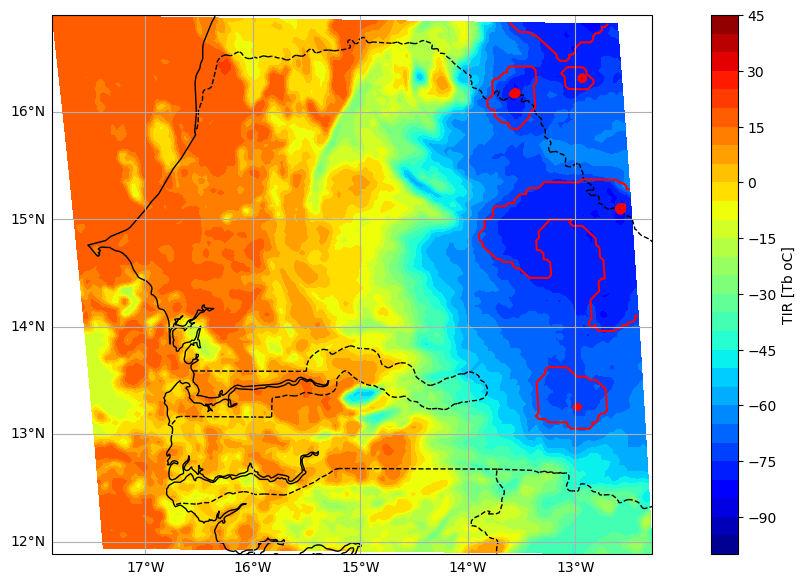

In [10]:
day = 96*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [11]:
# input data- cores_t_0: 
# starting at 
num_frames= 1   #8  # previous 2 hours of images to predict 1 hr later
t0= 0  #1   #*4 # # 1hr  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]



In [12]:
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]
ind = np.where(cores_t_0>0)
cores_t_0[ind] = 1

#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
#print(np.unique(cores_t_plus_xhr))


In [13]:
# open a file, where you stored the pickled data
#file = open('pkl_files/WA_subdomain_cores_2hr_back_multichannel.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#hist_cores_t_0= data[2]
#cores_t_plus_xhr= data[3]

In [14]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(cores_t_0.shape)
print(cores_t_plus_xhr.shape)


(8783, 128, 128)
(8783, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


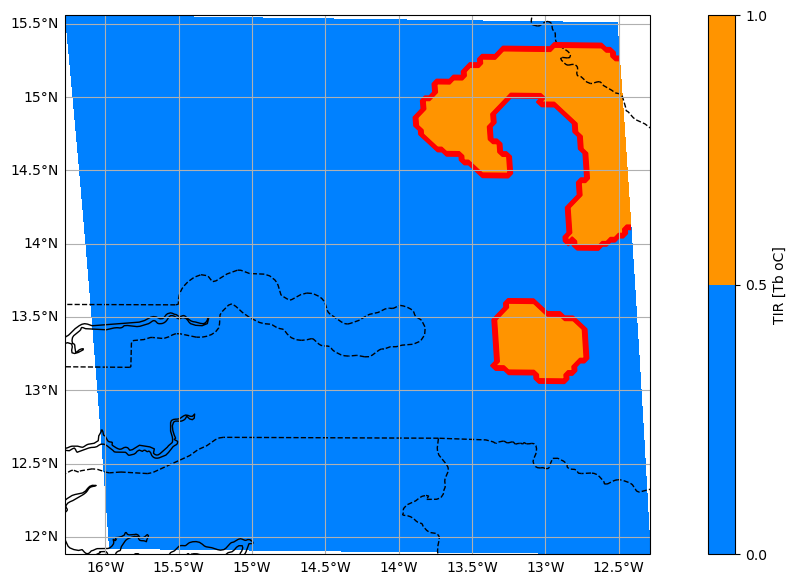

In [15]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores_t_0[day,:,:], colors='r')
#ax.contour(lon[:-a,b:], lat[:-a,b:], cores[day,:-a,b:], colors='r')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [16]:
# save variables 
with open('pkl_files/WA_subdomain_cores_4hr_back_1hr_forward.pkl', 'wb') as file: 
          pickle.dump([cores_t_0,tir_t_0,cores_t_plus_xhr], file) 
        

In [45]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [46]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)
x = layers.Dense(1, activation="sigmoid")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [47]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 128, 128, 8  7232      
                             )                                   
                                                                 
 batch_normalization_2 (Batc  (None, None, 128, 128, 8  32       
 hNormalization)             )                                   
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 128, 128, 8  4640      
                             )                                   
                                                                 
 batch_normalization_3 (Batc  (None, None, 128, 128, 8  32 

In [48]:
num_frames= 8   #24  # hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 100
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]

           
# normalize input data   - cores already 0-1
#x_normalize_factor = np.max(x_train)
#x_train = x_train/x_normalize_factor
#x_val = x_val/x_normalize_factor


In [49]:
print(x_train.shape)
print(x_val.shape)
#batch_size-val_samples
#batch_size

(997, 8, 128, 128, 1)
(100, 8, 128, 128, 1)


In [50]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10   #10 # 20
batch_size = 4 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
250/250 [==============================] - 298s 1s/step - loss: 0.6364 - val_loss: 0.5836 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - 298s 1s/step - loss: 0.5290 - val_loss: 0.4902 - lr: 0.0010
Epoch 3/10
250/250 [==============================] - 295s 1s/step - loss: 0.4408 - val_loss: 0.4025 - lr: 0.0010
Epoch 4/10
250/250 [==============================] - 297s 1s/step - loss: 0.3719 - val_loss: 0.3408 - lr: 0.0010
Epoch 5/10
250/250 [==============================] - 298s 1s/step - loss: 0.3155 - val_loss: 0.2903 - lr: 0.0010
Epoch 6/10
250/250 [==============================] - 304s 1s/step - loss: 0.2694 - val_loss: 0.2488 - lr: 0.0010
Epoch 7/10
250/250 [==============================] - 328s 1s/step - loss: 0.2313 - val_loss: 0.2146 - lr: 0.0010
Epoch 8/10
250/250 [==============================] - 528s 2s/step - loss: 0.1998 - val_loss: 0.1861 - lr: 0.0010
Epoch 9/10
250/250 [==============================] - 525s 2s/step - loss: 0.1735 - val_

In [38]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('pkl_files/WA_subdomain_trained_model_4hr_back_1hr_forward.pkl', 'wb') as file: 
 #   pickle.dump(model, file) 
        

In [24]:
#print(x_val.shape)
#print(predicted_frame.shape)
#print(np.where(all_frames>0.35))

In [51]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
# using x_val for now 
# all_frames=np.zeros((50,image_height,image_width, num_channels))

# for b in range(0,51,1):
batch_number = 25   #99 #25 #50
frames = x_val[batch_number,0:4,:,:,:] # 
#original_frames = x_val[batch_number,4:,:,:,0] # 
original_frames = y_val[batch_number,3:7,:,:,0] # 
pred_frames = np.zeros(frames.shape[:-1])
pred_frames = np.expand_dims(pred_frames, axis=-1)


# Predict a new set of 4 frames.
for i in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # Extend the set of prediction frames.
   # frames = np.concatenate((frames, predicted_frame), axis=0)
    pred_frames[i,:,:,:] =  predicted_frame


1/1 [==============================] - 0s 106ms/step


In [35]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [36]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 1hr


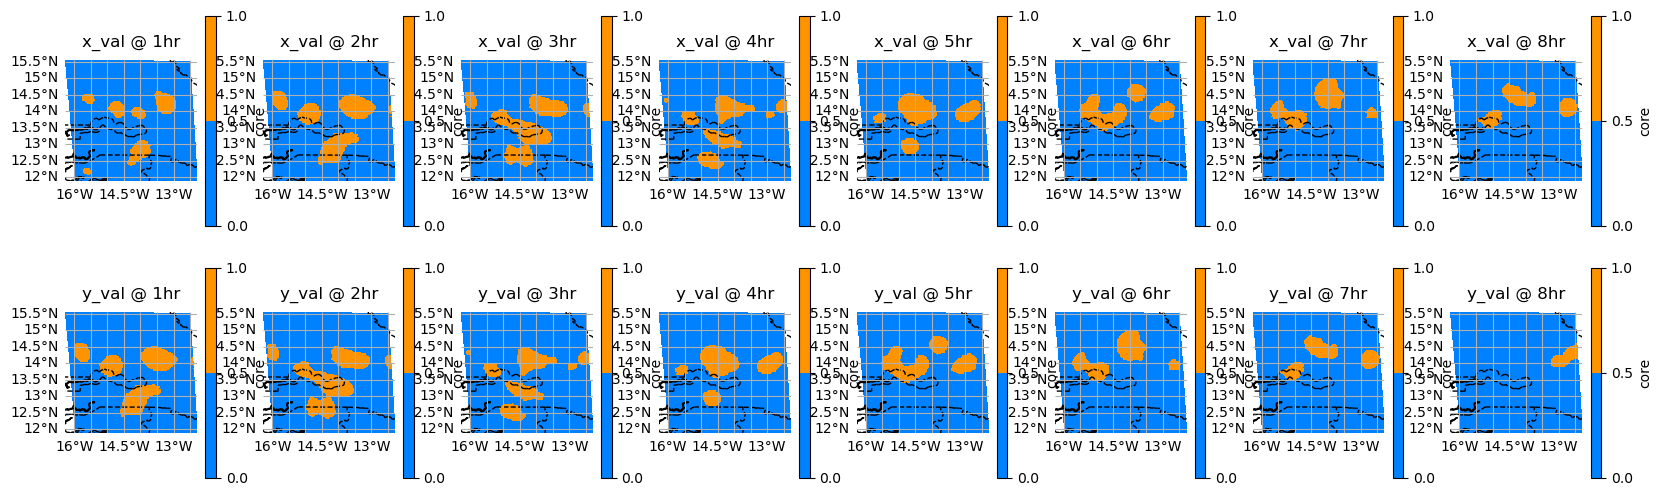

In [52]:
#x_val, y_val
#frames = x_val[batch_number,0:4,:,:,:] # 
#data = np.zeros((day,image_height,image_width))
#for x in range(0,8,1):
    #data[x] = np.squeeze(y_val[batch_number,x,:,:,0])
#batch_number= 25   #25        
#levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.1,0.2)]  #[0, 0.1, 0.2, 0.3,0.4]]
levels_custom=[[0, 0.5,1],np.arange(0,1.1,0.2)]  #[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 8, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(x_val[batch_number,idx,:,:,0]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"x_val @ {idx + 1}hr")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(y_val[batch_number,idx,:,:,0]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"y_val @ {idx + 1}hr")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 1hr')
plt.show()

In [53]:
print(frames.shape)
print(original_frames.shape)
print(pred_frames.shape)
#print(lon[:-a,b:].shape)
#print(lat[:-a,b:].shape)
#ind = np.where(frames[24:,:,:,0]>0.25)
#print((ind))

(4, 128, 128, 1)
(4, 128, 128)
(4, 128, 128, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


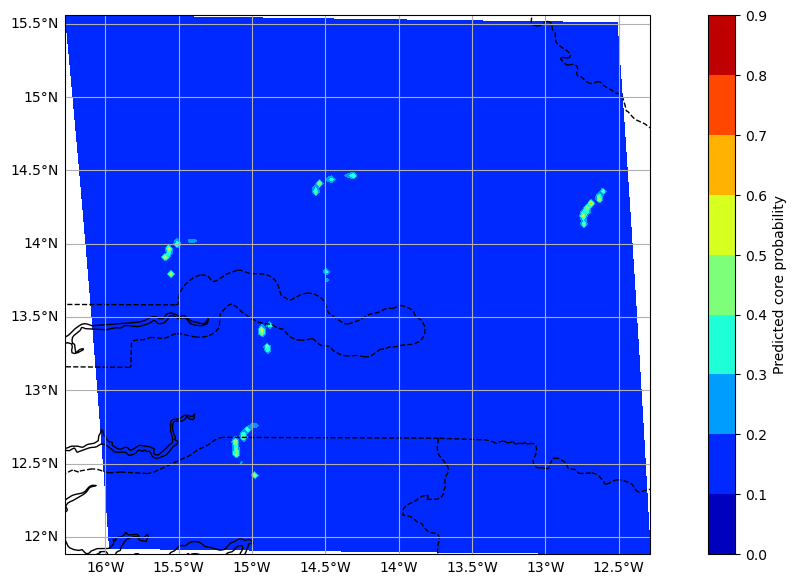

In [54]:
day = 0 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
#draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.25,0.5,0.75,1], cbar_label='Predicted core probability', cmap='jet')
draw_map(ax, np.squeeze(pred_frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:], levels=np.arange(0,1,0.1), cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


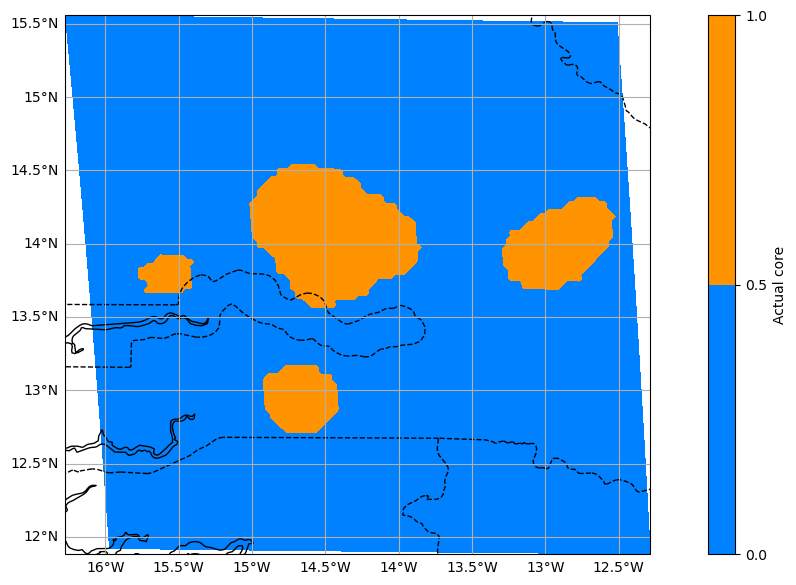

In [55]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[day,:,:]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.5,1], cbar_label='Actual core', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

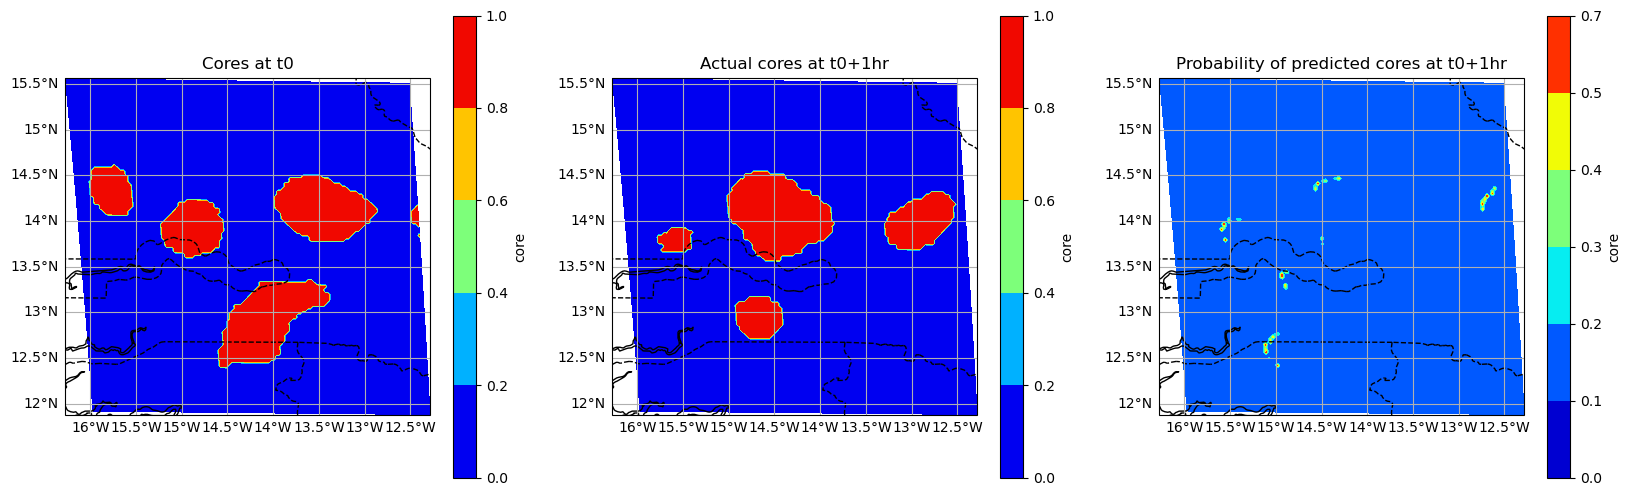

In [56]:
day = 3-2
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[0,:,:])
data[2] = np.squeeze(pred_frames[day-1,:,:,0])
titles = ['Cores at t0', 'Actual cores at t0+1hr', 'Probability of predicted cores at t0+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.1, 0.2, 0.3, 0.4,0.5,0.7]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[i],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 1hr


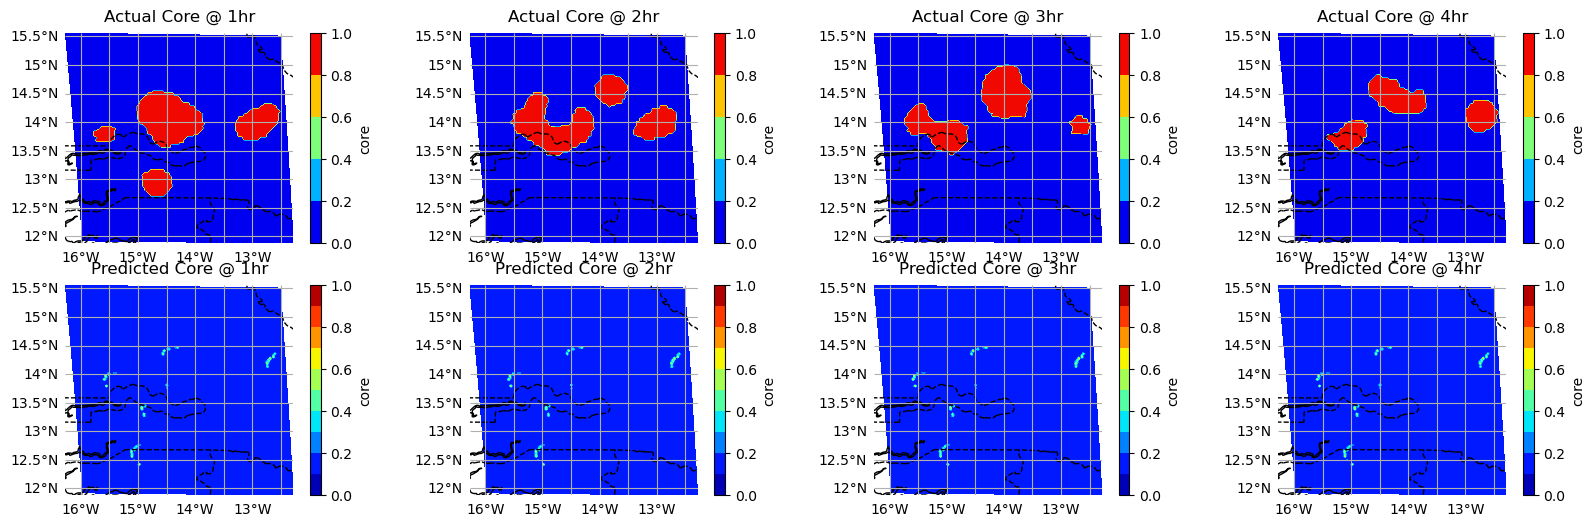

In [57]:
day = 6-2
data = np.zeros((day,image_height,image_width))
for x in range(0,4,1):
    data[x] = np.squeeze(pred_frames[x,:,:,0])
        
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.1,0.1)]  #[0, 0.1, 0.2, 0.3,0.4]]
#levels_custom=[[0, 0.5 ,1],[0, 0.5 ,1]]  #[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(original_frames[idx,:,:]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx + 1}hr")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= levels_custom[1])
    ax.set_title(f"Predicted Core @ {idx + 1}hr")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 1hr')
plt.show()